# This example contains 3 ipynb files.

In [1]:
import logging
import os

import torch
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import nn

from src.nn_handler import NNHandler
from MNIST_model import Net

## 1. Get training and validation datasets

In this case, the MNIST datasets will be used.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

training_data = datasets.MNIST(root='./data', train=True, download=True,
                               transform=transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                               ]))

test_data = datasets.MNIST(root='./data', train=False, download=True,
                           transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))
                           ]))

## 2. Initialize or load the NNHandler

When loaded, the handler is in the same state as when the instance was saved, minus the logging. If needed, it can be initialized with the `model.initialize_logger` method.

When the model architecture is defined in a '.py' file, the `NNHandler` can automatically retrieve and load the architecture. No import is needed. This does not work if the architecture is defined in a jupyter notebook. If a class with the same name is defined in the scope, the `NNHandler` will use it to load the model.

In [3]:
model = NNHandler.initialize(model_class=Net, device=device, optimizer_class=optim.Adamax,
                             loss_fn=nn.functional.nll_loss, train_data=training_data, val_data=test_data,
                             optimizer_kwargs={"lr": 0.01},
                             train_loader_kwargs={"batch_size": 1024, "shuffle": True},
                             val_loader_kwargs={"batch_size": 1000, "shuffle": True},
                             auto_save_interval=1, auto_save_path="models", auto_save_overwrite=True, 
                             auto_save_name="test_model_code",
                             logger_mode=NNHandler.Logging_Modes.FILE,
                             logger_filename="models/training.log",
                             logger_level=logging.INFO, save_model_code=True)

## 3. Train the model

In [4]:
model.train(5, val=True, debug=True)

Epoch: 5/5; Train loss: 0.230; Val loss: 0.067: 100%|██████████| 5/5 [00:50<00:00, 10.11s/it]


## 4. Load the model
The model saved at path 'model_state_epoch_5.pth' doesn't save the model code since it's code is defined in a jupyter notebook.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NNHandler.load("models/test_model_code_5.pth", device)

In [6]:
print(model.model_code)

import torch
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


Here even though Net is not defined in this notebook, the class `Net` exists so when loading the model, `torch` uses the class defined in the scope.

In [8]:
print(NNHandler.load("models/model_state_epoch_5.pth", device).model_code)

None


## 5. Plot results

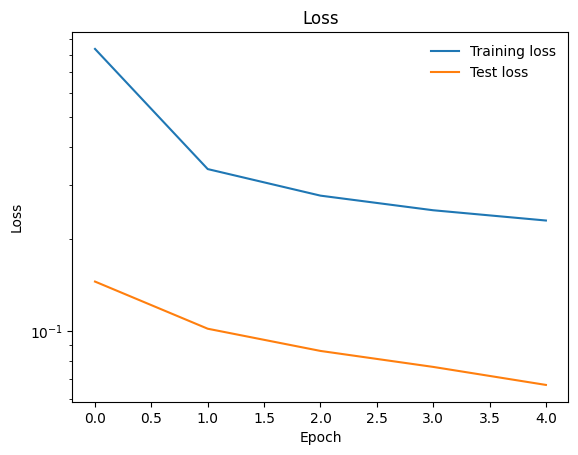

In [9]:
model.plot_losses(True)

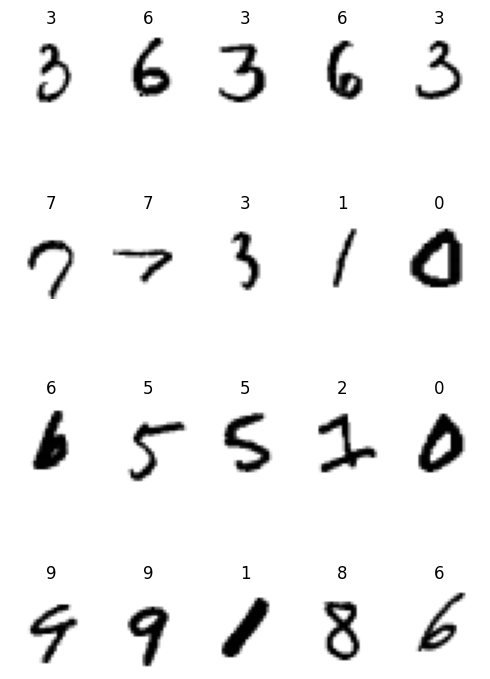

In [10]:
from matplotlib import pyplot as plt

# Plot n samples from the validation dataset with their predictions
n = 20
test_loader = torch.utils.data.DataLoader(test_data, batch_size=n, shuffle=True)
data_iter = iter(test_loader)
images, labels = data_iter.__next__()

# Get predictions
model.eval()
with torch.no_grad():
    images = images.to(device)
    outputs = model(images)

_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(5, n // 5 * 2))
for index in range(n):
    plt.subplot(n // 5, 5, index + 1)
    plt.axis('off')
    plt.imshow(images[index].cpu().numpy().squeeze(), cmap='gray_r')
    plt.title('%i' % predicted[index])

plt.tight_layout()

# 6. Open notebook 'save_model_code_example_2.ipynb' for the continuation of the example.